# Downstream visualizations using haplotypes

Imports.

In [1]:
import re # string search
from typing import Tuple, Union

import adjustText # prevent overlapping text
import matplotlib.pyplot as plt # make simple visualizations
import matplotlib.patches as patches # draw a custom rectangle
import numpy as np # data management
import pandas as pd # data management
import sklearn # PCA

# these classes must be imported specially
from sklearn.decomposition import PCA
from matplotlib.figure import SubFigure

import genotype_helpers # various helper functions & constants

print(f'''
This notebook adds:
adjustText version {adjustText.__version__}, 
scikit-learn version {sklearn.__version__}
''')


This helper file uses:
Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)],
Matplotlib version 3.7.1, 
NumPy version 1.24.3,
pandas version 1.5.3, 
pyMSAviz version 0.4.0,
scikit-allel version 1.3.6


This notebook adds:
adjustText version 0.8, 
scikit-learn version 1.2.2



Constants.

In [2]:
sample_info = pd.read_csv(genotype_helpers.SAMPLE_INFO_FILE, index_col = 'rfid')
y_groups = pd.read_csv(genotype_helpers.Y_GROUPS_FILE, index_col = 'rfid')
mt_groups = pd.read_csv(genotype_helpers.MT_GROUPS_FILE, index_col = 'rfid')

# remove notes about what founders this chromosome is from, e.g. Y1 (ACI) -> Y2
sample_info = sample_info.join(y_groups['Y_group'].str.slice(0, 2))
sample_info = sample_info.join(mt_groups['MT_group'].str.slice(0, 3))

# extract numeric YYYY from YYYY-MM-DD string (int can't handle np.nan)
sample_info['yob'] = sample_info['dob'].str.slice(stop = 4).astype(float)

seq_methods = ['lcWGS', 'ddGBS']

# all PCAs use 2 principal components
pca = PCA(n_components = 2)

# style for lines which point from labels to their points
label_lines = dict(arrowstyle = '-', color = 'k', lw = 0.5, zorder = 5)

Helper functions.

In [3]:
def subset_rfids(chrom: str, haplotype_number: int, 
                 method: Union[str, int]) -> Tuple[pd.Series, str]:
    """Subset RFIDs by haplotype group and sequencing method.
    
    Parameters
    ----------
    chrom: str
        Chromosome these data are for; for plot title.
    haplotype_number: int
        Arbitrary number assigned to this haplotype; either 1 or 2.
    method: str or int
        Sequencing method used; "lcWGS"/"ddGBS", or 0/1 to index `seq_methods`
    """

    # build up the full haplotype name and sequencing method used
    haplotype = f'{chrom}{haplotype_number}'
    if type(method) == int: method = seq_methods[method]

    ids = sample_info.loc[(sample_info[f'{chrom}_group'] == haplotype)
                           & (sample_info['seq_method'] == method)].index

    return ids, f'{chrom}{haplotype_number} {method}'

def plot_births_over_time(chrom: str) -> None:
    """Make and save a plot of haplotype distribution over time.

    The plot show year of birth on the X-axis and percentage of
    samples with a given haplotype on the Y-axis.

    Parameters
    ----------
    chrom: str
        Chromosome these data are for; for plot title.
    """
    
    # count births in each haplotype by year
    group_col = sample_info[f'{chrom}_group']
    group1 = sample_info.loc[group_col == f'{chrom}1', 'yob'].value_counts()
    group2 = sample_info.loc[group_col == f'{chrom}2', 'yob'].value_counts()
    total = group1 + group2

    # plot % over time
    plt.scatter(group1.index, 100 * group1 / total, label = f'{chrom}1')
    plt.scatter(group2.index, 100 * group2 / total, label = f'{chrom}2')
    plt.legend(loc = 'upper left')
    # prevent auto-scale of the Y-axis
    plt.ylim(0, 100)
    
    plt.title(f'{chrom} haplotype frequencies over time')    
    plt.xlabel('Birth year')
    plt.ylabel('Frequency (%)')

    plt.gcf().set_size_inches(5, 5)
    genotype_helpers.save_plot(f'{chrom}_over_time')

def plot_het_distribution(fig: SubFigure, chrom: str, tag: str) -> None:
    """Make a plot of heterozygosity across the chromosome.

    The plot show chromosome position on the X-axis and percentage of
    nonmissing calls which are heterozygous on the Y-axis.
    Four subplots are generated, one for each 
    combination of haplotype and sequencing method.

    Parameters
    ----------
    fig: SubFigure
        Figure to put the plot on.
    chrom: str
        Chromosome these data are for; for plot title.
    tag: str
        Letter to use as a panel tag on the top left.
    """
    
    # load all confidentally imputed genotypes from shallow-sequencing
    geno = genotype_helpers.get_genotypes(
        genotype_helpers.SHALLOW_MODERN_FILE, chrom, format = 'allele_num', 
        
        allow_het = True, 
        use_maf_filter = False, use_miss_filter = False
    )
    # heterozygous biallelic SNPs calls are `0/1` -> `0 * 10 + 1 = 1`
    is_het = (geno == 1)

    axs = fig.subplots(2, 2)

    # split by haplotype (row) and sequencing method (col)
    for i in range(2):
        for j in range(2):
            ids, description = subset_rfids(chrom, haplotype_number = i + 1, 
                                            method = j)
            
            # heterozygosity percent vs. SNP position
            axs[i][j].scatter(geno.columns, 100 * is_het.loc[ids].mean())
            # no need to put base-pair position on x-axis
            axs[i][j].set_xticks([])
            
            axs[i][j].set_title(f'{description} samples')

    fig.suptitle(f'Heterozygosity in {chrom}')
    fig.text(0.5, 0.05, f'Base-pair position along {chrom}', 
            ha = 'center', va = 'center')
    fig.text(0.05, 0.5, 'Percentage of rats with an 0/1 call', 
            ha = 'center', va = 'center', rotation = 'vertical')
    genotype_helpers.write_panel_tag(tag, x = -0.2, y = 1.2, ax = axs[0][0])

def pca_biplot(ax: plt.Axes, chrom: str, tag: str) -> None:
    """Make a PCA biplot.

    Visualize PC1 and PC2 against each other for shallow-sequenced
    modern HS rats as well as founder samples. Missing data is
    imputed as exactly halfways between homozygous genotypes.

    Parameters
    ----------
    ax: plt.Axes
        Axes to put the plot on.
    chrom: str
        Chromosome to pull data for; for plot title and loading genotypes.
    tag: str
        Letter to use as a panel tag on the top left.
    """

    # load genotypes, normalized so alternate = 1 instead of 11
    modern = genotype_helpers.get_genotypes(
        genotype_helpers.SHALLOW_MODERN_FILE, chrom, format = 'allele_num'
        ) / 11
    founders = genotype_helpers.get_genotypes(
        genotype_helpers.FOUNDERS_FILE, chrom, format = 'allele_num', 
        
        variant_subset = modern.columns, 
        use_maf_filter = False, use_miss_filter = False
    ) / 11

    # use mean imputation for missingness in modern samples
    modern = modern.fillna(modern.mean())
    all_geno = pd.concat([founders, modern])
    pcs = pd.DataFrame(pca.fit(modern).transform(all_geno), 
                       index = all_geno.index, columns = ['PC1', 'PC2'])

    # ---- plot modern samples (small dots) ----
    
    # split by haplotype (row) and sequencing method (col)
    for i in range(2):
        for j in range(2):
            ids, description = subset_rfids(chrom, haplotype_number = i + 1, 
                                            method = j)
            subset_pcs = pcs.filter(ids, axis = 'index')

            ax.scatter(subset_pcs['PC1'], subset_pcs['PC2'], s = 0.5,
                       color = genotype_helpers.COLORBLIND_PALETTE[i * 2 + j], 
                       label = description)
    
    # make a legend with large dots for ease of reading
    lgnd = ax.legend(loc = 'upper center')
    for handle in lgnd.legend_handles: handle.set_sizes([5])
    
    # --- plot founder samples (label by name) ----

    texts = []
    for name in founders.index:
        cur_x = pcs.loc[name, 'PC1']
        cur_y = pcs.loc[name, 'PC2']

        # random shift to help with overlapping text
        texts.append(ax.text(cur_x + np.random.random() / 100, 
                             cur_y + np.random.random() / 100, 
                             name, zorder = 10))
        ax.plot(cur_x, cur_y, 'o', color = 'black', zorder = 6)
    
    # ---- final touches ----

    ax.set_title(f'PCA on {chrom}')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    
    genotype_helpers.write_panel_tag(tag, x = -0.05, y = 1.05, ax = ax)

    # prevent overlapping text
    adjustText.adjust_text(texts, ax = ax, arrowprops = label_lines, lim = 5000)

Plot haplotype percentages over time.

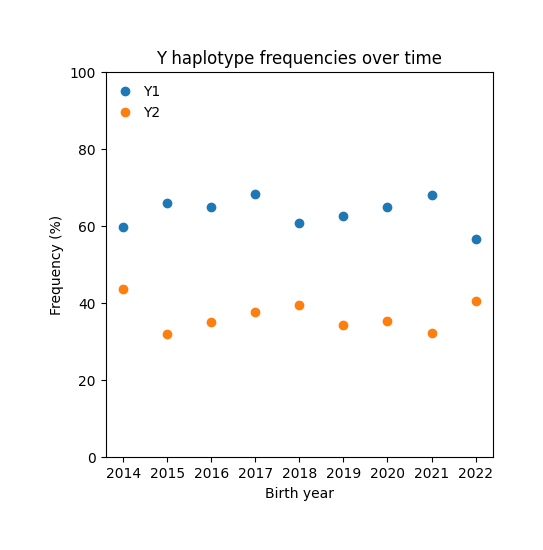

In [4]:
# Figure 1C
plot_births_over_time('Y')

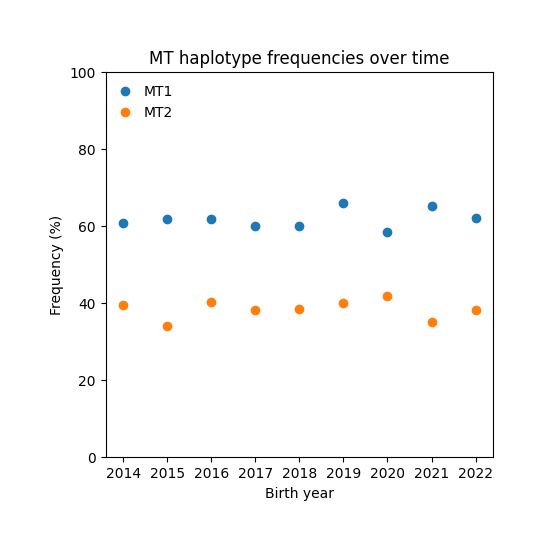

In [5]:
# Figure 2C
plot_births_over_time('MT')

Plot distribution of heterozygosity by haplotype and sequencing method. This is
*Figure S1*

Read 5227 variants across 15120 samples
7637 samples removed for not being male
Setting missing calls to np.nan
Filtering out 300 variants for INFO score < 0.5
Genotypes for 7483 rats across 4927 variants
Read 117 variants across 15120 samples
Setting missing calls to np.nan
Filtering out 0 variants for INFO score < 0.85
Genotypes for 15120 rats across 117 variants


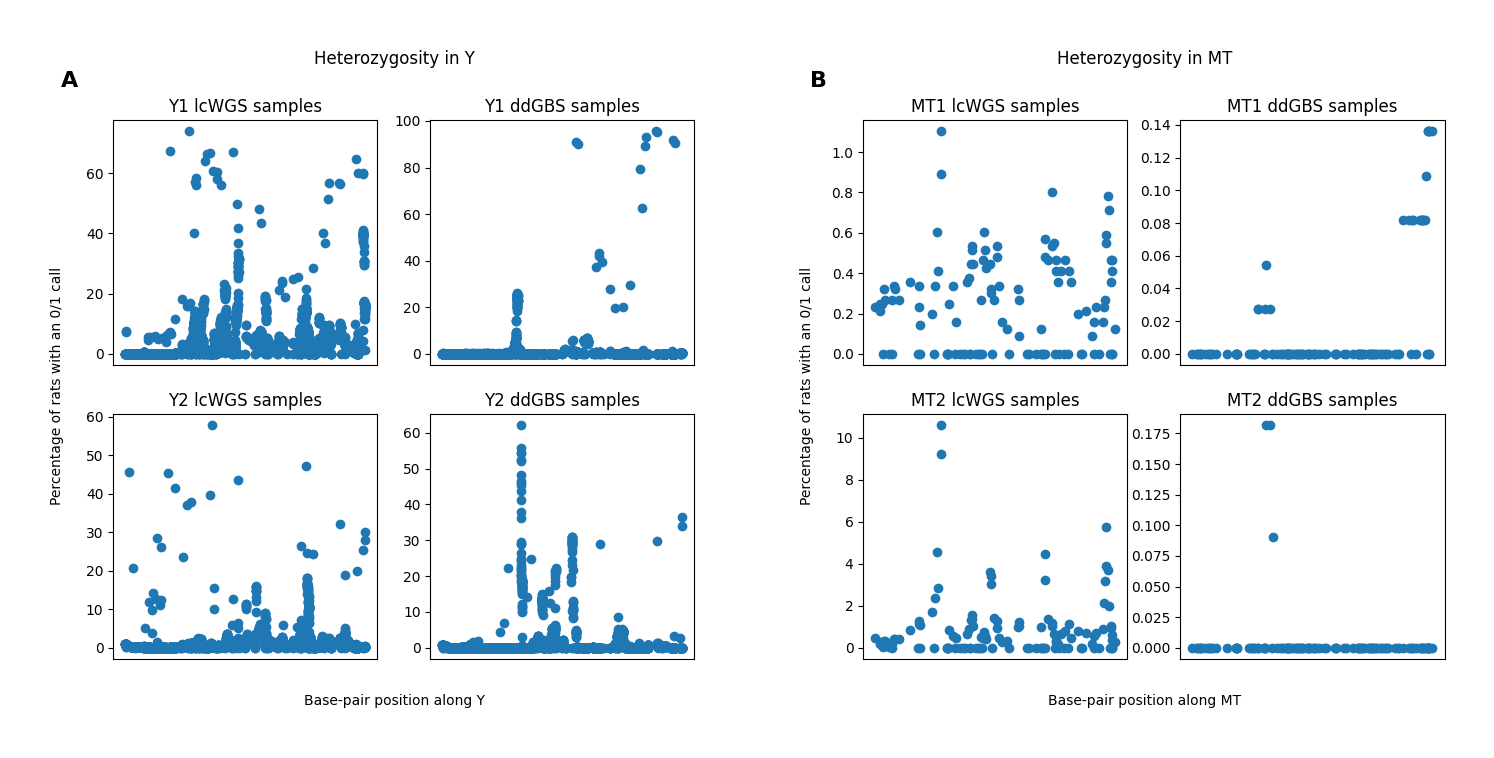

In [6]:
(fig1, fig2) = plt.figure(figsize = (15, 7)).subfigures(nrows = 1, ncols = 2)
plot_het_distribution(fig1, 'Y', tag = 'A')
plot_het_distribution(fig2, 'MT', tag = 'B')
genotype_helpers.save_plot('heterozygosity')

Make PCA biplots. This is *Figure S3*.

Read 5227 variants across 15120 samples
7637 samples removed for not being male
Setting heterozygous calls to missing
Setting missing calls to np.nan
Filtering out 300 variants for INFO score < 0.5
Filtering out 217 variants for MAF=0
Filtering out 578 variants for % nonmissing calls < 75
Filtering out 12 samples for % nonmissing calls < 50
Genotypes for 7471 rats across 4132 variants
Read 18499 variants across 8 samples
0 samples removed for not being male
14367 variants removed for not being in the given subset
Setting heterozygous calls to missing
Setting missing calls to np.nan
Genotypes for 8 rats across 4132 variants
Read 117 variants across 15120 samples
Setting heterozygous calls to missing
Setting missing calls to np.nan
Filtering out 0 variants for INFO score < 0.85
Filtering out 40 variants for MAF=0
Filtering out 0 variants for % nonmissing calls < 75
Filtering out 149 samples for % nonmissing calls < 50
Genotypes for 14971 rats across 77 variants
Read 122 variants across 8

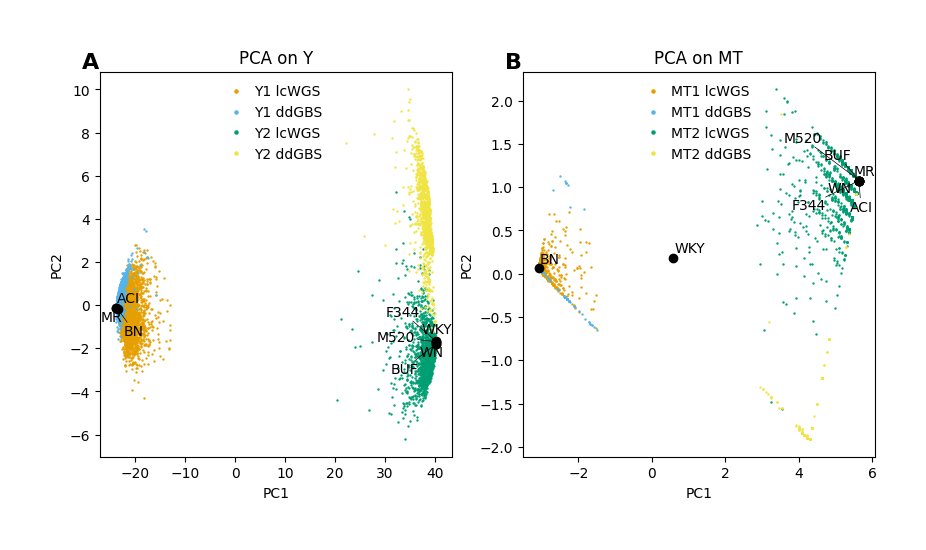

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
pca_biplot(ax1, 'Y', tag = 'A')
pca_biplot(ax2, 'MT', tag = 'B')
genotype_helpers.save_plot('pca')

Load MT genotypes with absolutely no filters applied.

In [8]:
mt_modern = genotype_helpers.get_genotypes(
    genotype_helpers.SHALLOW_MODERN_FILE, 'MT', format = 'allele_num', 
    
    use_maf_filter = False, use_miss_filter = False
    )
is_missing = mt_modern.isnull()
no_maf = genotype_helpers.are_variants_maf_0(mt_modern)

Read 117 variants across 15120 samples
Setting heterozygous calls to missing
Setting missing calls to np.nan
Filtering out 0 variants for INFO score < 0.85
Genotypes for 15120 rats across 117 variants


In [9]:
mt_founders = genotype_helpers.get_genotypes(
    genotype_helpers.FOUNDERS_FILE, 'MT', format = 'nucleotide',
    
    use_maf_filter = False, use_miss_filter = False
)

Read 122 variants across 8 samples
Genotypes for 8 rats across 122 variants


In [10]:
mt_depth = pd.read_csv(genotype_helpers.MT_DEPTH_FILE, index_col = 0)

Determine restriction sites.

In [11]:
ref_mt = ''
with open(genotype_helpers.MT_REF_FILE) as fasta:
    # skip sample information line
    fasta.readline()
    for line in fasta: ref_mt += line.strip()

In [12]:
# string -> list of characters conversion
mt1_seq = list(ref_mt)
mt2_seq = list(ref_mt)

# update MT1 and MT2 sequences with variants present in founder strains
for pos in mt_founders.columns:
    # VCF is 1-indexed, Python lists are 0-indexed
    mt1_seq[pos - 1] = mt_founders.loc['BN', pos]
    mt2_seq[pos - 1] = mt_founders.loc['BUF', pos]

# list of characters -> string conversion
mt1_seq = ''.join(mt1_seq)
mt2_seq = ''.join(mt2_seq)

[Gileta *et al.* 2020](https://doi.org/10.1534/g3.120.401325) has the 
recognition sequences for the restriction enzymes used.

In [13]:
print('Neither MT1 nor MT2 has PstI restrction sites (CTGCAG): '
      f'MT1 has none = {not list(re.finditer("CTGCAG", mt1_seq))}, '
      f'MT2 has none = {not list(re.finditer("CTGCAG", mt1_seq))}')
mt1_cuts = [m.end() for m in re.finditer('CATG', mt1_seq)]
mt2_cuts = [m.end() for m in re.finditer('CATG', mt2_seq)]

Neither MT1 nor MT2 has PstI restrction sites (CTGCAG): MT1 has none = True, MT2 has none = True


Plot MT missingness by haplotype and sequencing method. This is *Figure S4*.

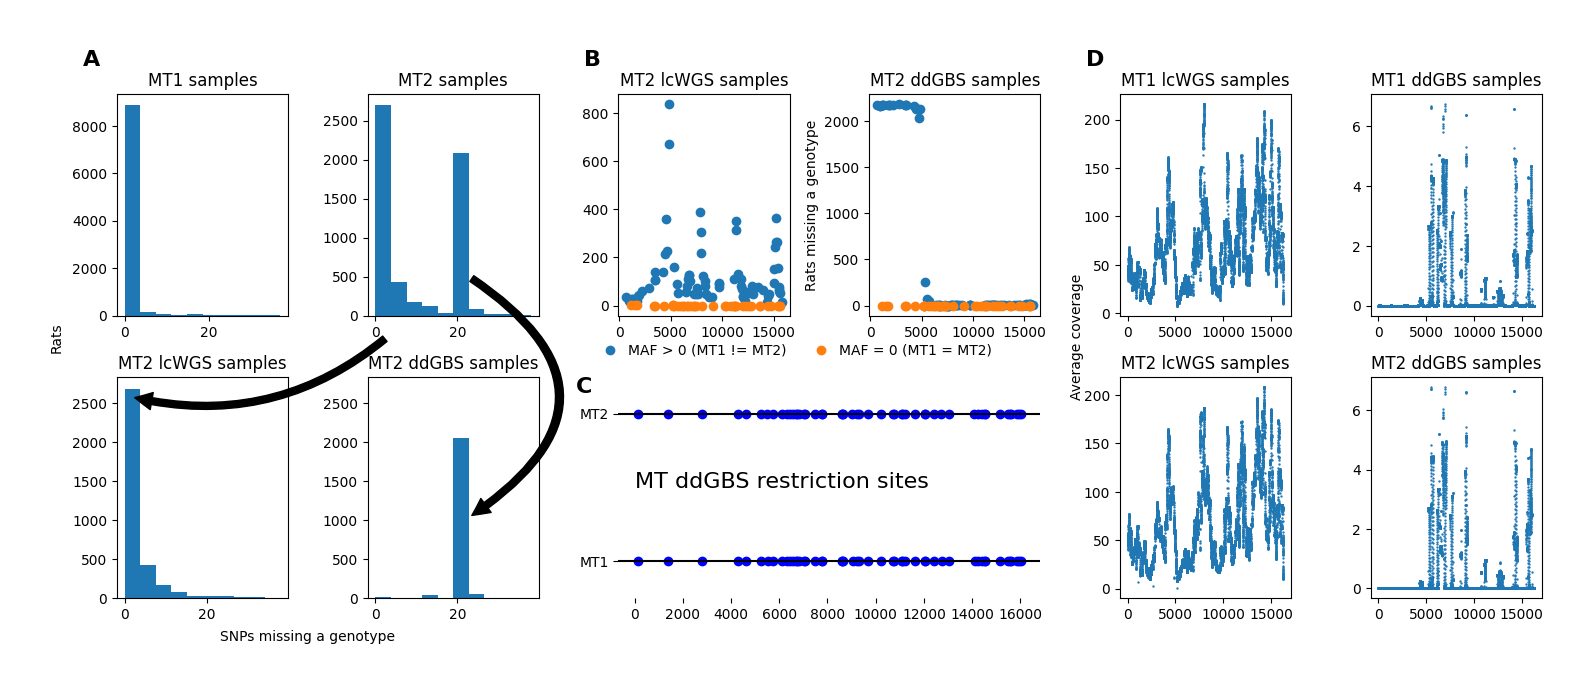

In [14]:
fig, axs = plt.subplot_mosaic([
    ['MT1', 'MT2', 'lcWGS_dots', 'ddGBS_dots', 'MT1_lcWGS', 'MT1_ddGBS'],
    ['lcWGS_hist', 'ddGBS_hist', 'res_cut', 'res_cut', 'MT2_lcWGS', 'MT2_ddGBS']
    ])

# missingness histograms by haplotype
for haplo in sample_info['MT_group'].dropna().unique():
    haplo_ids = sample_info.loc[sample_info['MT_group'] == haplo].index
    axs[haplo].hist(is_missing.loc[haplo_ids].sum(axis = 1))
    axs[haplo].set_title(f'{haplo} samples')

# tracking down the missingness in MT2
for method in seq_methods:
    ids, _ = subset_rfids('MT', haplotype_number = 2, method = method)

    # MT2 missingness histograms by sequencing method
    ax_name = f'{method}_hist'

    # histogram of per-rat missingness
    axs[ax_name].hist(is_missing.loc[ids].sum(axis = 1))
    # use the same scale as the M2 method-combined histogram, for context
    axs[ax_name].sharex(axs['MT2'])
    axs[ax_name].sharey(axs['MT2'])
    axs[ax_name].set_title(f'MT2 {method} samples')

    # MT2 missingness scatterplot by sequencing method
    ax_name = f'{method}_dots'

    # plot MAF>0 dots, then MAF=0
    axs[ax_name].scatter(mt_modern.columns[~no_maf],
                         is_missing.loc[ids, ~no_maf].sum(axis = 0),
                         label = 'MAF > 0 (MT1 != MT2)')
    axs[ax_name].scatter(mt_modern.columns[no_maf], 
                         is_missing.loc[ids, no_maf].sum(axis = 0),
                         label = 'MAF = 0 (MT1 = MT2)')
    
    axs[ax_name].set_title(f'MT2 {method} samples')

# coverage scatterplots
for haplotype_number in [1, 2]:
    for method in seq_methods:
        ids, description = subset_rfids('MT', haplotype_number, method)

        ax_name = f'MT{haplotype_number}_{method}'
        axs[ax_name].scatter(mt_depth.index, mt_depth[ids].mean(axis = 1), 
                             s = 0.5)
        axs[ax_name].set_title(f'{description} samples')

# restriction cut sites
axs['res_cut'].axhline(y = 1, color = 'black')
axs['res_cut'].scatter(x = mt1_cuts, y = [1] * len(mt1_cuts), color = 'blue')
axs['res_cut'].axhline(y = 2, color = 'black')
axs['res_cut'].scatter(x = mt2_cuts, y = [2] * len(mt2_cuts), color = 'blue')
genotype_helpers.hide_borders(axs['res_cut'])
axs['res_cut'].set_ylim(0.75, 2.25)
axs['res_cut'].set_yticks(ticks = [1, 2], labels = ['MT1', 'MT2'])
axs['res_cut'].text(0, 1.5, 'MT ddGBS restriction sites', fontsize = 16)

# tags
genotype_helpers.write_panel_tag('A', x = -0.2, y = 1.2, ax = axs['MT1'])
genotype_helpers.write_panel_tag('B', x = -0.2, y = 1.2, ax = axs['lcWGS_dots'])
genotype_helpers.write_panel_tag('C', x = -0.1, y = 1, ax = axs['res_cut'])
genotype_helpers.write_panel_tag('D', x = -0.2, y = 1.2, ax = axs['MT1_lcWGS'])

# axis labels
fig.text(0, 0.5, 'Rats', rotation = 90, ha = 'center', va = 'center')
fig.text(1 / 6, 0, 'SNPs missing a genotype', ha = 'center', va = 'center')
axs['ddGBS_dots'].set_ylabel('Rats missing a genotype')
fig.text(0.68, 0.5, 'Average coverage', rotation = 90, 
         ha = 'center', va = 'center')

fig.set_size_inches(15, 6)
fig.tight_layout()
# legend goes below plot
axs['ddGBS_dots'].legend(bbox_to_anchor = (0.75, -0.1), ncol = 2,
                         loc = 'upper right', borderaxespad = 0.)

# arrows to trace where MT2 missingness peaks come from
lcwgs_arrow = patches.FancyArrowPatch((0.22, 0.5), (0.05, 0.4), 
                                      mutation_scale = 25, color = 'k',
                                      connectionstyle = 'arc3, rad=-0.25',
                                       transform = fig.transFigure)
ddgbs_arrow = patches.FancyArrowPatch((0.275, 0.6), (0.275, 0.2), 
                                      mutation_scale = 25, color = 'k',
                                      connectionstyle = 'arc3, rad=-0.75',
                                       transform = fig.transFigure)
fig.patches.extend([lcwgs_arrow, ddgbs_arrow])

genotype_helpers.save_plot('MT_missing')